In [ ]:
!pip install -q osmnx

In [38]:
import graph_search_algorithm_compilation
import matplotlib.pyplot as plt
import networkx as nx
# import nx_cugraph as nxcg
import random
import time
import osmnx as ox
import geopandas as gpd
import json
import dask.bag as db

# from joblib import Parallel, delayed
from dask import delayed
from tqdm import tqdm
from dask.distributed import Client
from dask import delayed, compute

In [39]:
if 'client' in globals():
    client.close()
client = Client(memory_limit='auto')

2024-11-01 13:50:29,149 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


In [40]:
# Generate a random weighted MultiDiGraph for the simulation
def generate_random_graph(num_nodes, prob=0.1, max_weight=10):
    G = nx.generators.random_graphs.gnp_random_graph(num_nodes, prob, directed=True)
    G = nx.MultiDiGraph(G)  # Convert to MultiDiGraph to allow multiple edges between nodes

    # Create a static list of edges to avoid modifying G.edges() while iterating
    edges = list(G.edges())
    for u, v in edges:
        weight = random.randint(1, max_weight)
        G.add_edge(u, v, length=weight)  # Set the 'length' attribute as the primary weight

    return G

In [41]:
# Apply flood conditions to the graph
def apply_flood_conditions(G, flood_probability):
    flooded_edges = []
    for u, v in list(G.edges()):
        if random.random() < flood_probability:
            flooded_edges.append((u, v))
            G.remove_edge(u, v)  # Remove the flooded edges from the graph
    return G

In [42]:
algorithms = {
    "Dijkstra": graph_search_algorithm_compilation.dijkstra_search,
    "Floyd-Warshall": graph_search_algorithm_compilation.floyd_warshall_search,
    "Bellman-Ford": graph_search_algorithm_compilation.bellman_ford_search,
    "Bidirectional": graph_search_algorithm_compilation.bidirectional_search,
    "Dynamic": graph_search_algorithm_compilation.dynamic_shortest_path,
    # "D* Lite": graph_search_algorithm_compilation.d_star_lite,
    "A* Search": graph_search_algorithm_compilation.a_star_search,
    # "MCTS": graph_search_algorithm_compilation.monte_carlo_tree_search,
    "Yen's K-Shortest Paths": graph_search_algorithm_compilation.yen_k_shortest_paths,
    # "ACO": graph_search_algorithm_compilation.ant_colony_optimization,
}

In [43]:
def create_subgraph(G):
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    SG = G.__class__()
    SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)
    if SG.is_multigraph():
        SG.add_edges_from(
            (n, nbr, key, d)
            for n, nbrs in G.adj.items()
            if n in largest_wcc
            for nbr, keydict in nbrs.items()
            if nbr in largest_wcc
            for key, d in keydict.items()
        )
    else:
        SG.add_edges_from(
            (n, nbr, d)
            for n, nbrs in G.adj.items()
            if n in largest_wcc
            for nbr, d in nbrs.items()
            if nbr in largest_wcc
        )
    SG.graph.update(G.graph)
    return SG

In [44]:
def create_coarse_graph(G, communities):
    supernode_graph = nx.Graph()

    # Add nodes representing communities
    for i in range(len(communities)):
        supernode_graph.add_node(i)

    # Build node-to-community mapping in parallel using dask.bag
    community_bag = db.from_sequence(enumerate(communities))
    node_to_community = community_bag.map(lambda x: [(node, x[0]) for node in x[1]]) \
        .flatten().compute()
    node_to_community = dict(node_to_community)

    # Process edges in parallel
    edges_bag = db.from_sequence(G.edges(data=True))

    def process_edge(edge):
        u, v, data = edge
        if 'length' in data:
            comm_u = node_to_community.get(u)
            comm_v = node_to_community.get(v)
            if comm_u is not None and comm_v is not None and comm_u != comm_v:
                if supernode_graph.has_edge(comm_u, comm_v):
                    current_weight = supernode_graph[comm_u][comm_v]['weight']
                    supernode_graph[comm_u][comm_v]['weight'] = min(current_weight, data['length'])
                else:
                    supernode_graph.add_edge(comm_u, comm_v, weight=data['length'])

    # Compute in parallel
    edges_bag.map(process_edge).compute()
    return supernode_graph

def hierarchical_shortest_path(G, supernode_graph, communities, source, target, algorithm):
    # Build node-community map in parallel
    community_bag = db.from_sequence(enumerate(communities))
    node_community_map = dict(community_bag.map(lambda x: [(node, x[0]) for node in x[1]]).flatten().compute())

    # Step 1: Find the communities in parallel
    source_community = delayed(lambda: node_community_map.get(source))()
    target_community = delayed(lambda: node_community_map.get(target))()
    source_community, target_community = compute(source_community, target_community)

    # Step 2: Find the shortest path in the supernode graph
    superpath = nx.shortest_path(supernode_graph, source=source_community, target=target_community)

    # Step 3: Refinement within communities
    full_path = [source]
    current_node = source

    for i in range(len(superpath) - 1):
        community1, community2 = superpath[i], superpath[i + 1]

        # Find connecting nodes in parallel
        boundary_nodes_bag = db.from_sequence(communities[community1]).cartesian(db.from_sequence(communities[community2]))
        boundary_nodes = boundary_nodes_bag.filter(lambda x: G.has_edge(x[0], x[1])).compute()

        if not boundary_nodes:
            raise Exception("No path between these communities in the original graph")

        # Find boundary node with minimum length using parallel mapping
        def edge_length(pair):
            edge_data = G.get_edge_data(pair[0], pair[1], default={})
            return min(data.get('length', float('inf')) for data in edge_data.values()) if edge_data else float('inf')

        boundary_node = min(boundary_nodes, key=edge_length)

        # Find shortest path from current_node to boundary_node in parallel
        path_within_community = algorithm(G, source=current_node, target=boundary_node[0])
        full_path.extend(path_within_community[1:])

        # Set up next node for iteration
        current_node = boundary_node[1]

    # Final path segment
    final_path = algorithm(G, source=current_node, target=target, weight='length')
    full_path.extend(final_path[1:])

    return full_path


In [45]:
# Parallel execution using Dask
@delayed
def evaluate_algorithm(G, supernode_graph, communities, source, target, algorithm):
    start_time = time.time()
    try:
        # Call the algorithm with (G, source, target, weight)
        path = hierarchical_shortest_path(G, supernode_graph, communities, source, target, algorithm)
        duration = time.time() - start_time
        if path is None:
            return float('inf'), []  # Infinite cost for no path found
        return duration, path  # Return computation time and the path
    except Exception as e:
        return float('inf'), []  # Infinite cost for errors


# Run algorithms in parallel using Dask
def run_in_parallel(algorithms, graph, source, target):
    communities, supernode_graph = detect_communities_and_supernode_graph(graph)

    delayed_results = [
        evaluate_algorithm(graph, supernode_graph, communities, source, target, algo_func) 
        for algo_func in algorithms.values()
    ]

    results = compute(*delayed_results)
    return results


# Step 1: Detect Louvain communities and create the supernode graph
def detect_communities_and_supernode_graph(G, weight='weight'):
    communities = nx.community.louvain_communities(G, weight)
    supernode_graph = create_coarse_graph(G, communities)
    return communities, supernode_graph
    

# Monte Carlo Simulation: Run all algorithms in parallel on the same graph
def monte_carlo_simulation(graph, num_iterations):
    algorithm_performance = {name: [] for name in algorithms.keys()}  # Track performance for each algorithm

    source = random.choice(list(graph.nodes()))
    target = random.choice(list(graph.nodes()))

    # Ensure source and target are not the same
    while source == target:
        target = random.choice(list(graph.nodes()))

    # Step 4: Evaluate all algorithms in parallel over the same graph, flooded conditions, and source/target
    for _ in tqdm(range(num_iterations)):
        results = run_in_parallel(algorithms, graph.copy(), source, target)

        # Store results in performance dictionary
        for algo_name, result in zip(algorithms.keys(), results):
            algorithm_performance[algo_name].append(result)

    return algorithm_performance

In [46]:
# Choose the best algorithm based on the performance and return the best result
def choose_best_algorithm(algorithm_performance):
    # Calculate average performance for each algorithm
    avg_performance = {
        algo: sum(duration for duration, _ in times) / len(times)
        for algo, times in algorithm_performance.items()
    }

    # Select the algorithm with the lowest average time
    best_algorithm = min(avg_performance, key=avg_performance.get)

    # Output the performance of all algorithms
    print(f"Best algorithm: {best_algorithm}")
    for algo, avg_time in avg_performance.items():
        print(f"{algo}: {avg_time:.4f} seconds (average)")

    # Return the best algorithm and its last run output (path)
    best_run = algorithm_performance[best_algorithm][-1]  # Get the last run result
    return best_algorithm, best_run[1]  # Return the algorithm name and its path

In [47]:
# Monte Carlo Simulation Parameters
iterations = 1000  # Number of Monte Carlo iterations
graph_size = 50    # Number of nodes in the graph
flooded_road_probability = 0.1  # Probability that a road gets flooded

G = generate_random_graph(graph_size)

# apply flood conditions once
graph = apply_flood_conditions(G, flooded_road_probability)
# graph = nxcg.from_networkx(graph)

In [ ]:
# Run the simulation
algorithm_performance = monte_carlo_simulation(graph, iterations)

  6%|▋         | 63/1000 [00:39<08:28,  1.84it/s]

Best algorithm: Bidirectional
Dijkstra: 0.0006 seconds (average)
Floyd-Warshall: inf seconds (average)
Bellman-Ford: 0.0330 seconds (average)
Bidirectional: 0.0001 seconds (average)
Dynamic: 0.0005 seconds (average)
A* Search: 0.0005 seconds (average)
Yen's K-Shortest Paths: inf seconds (average)
Best path found by Bidirectional: [33, 10]


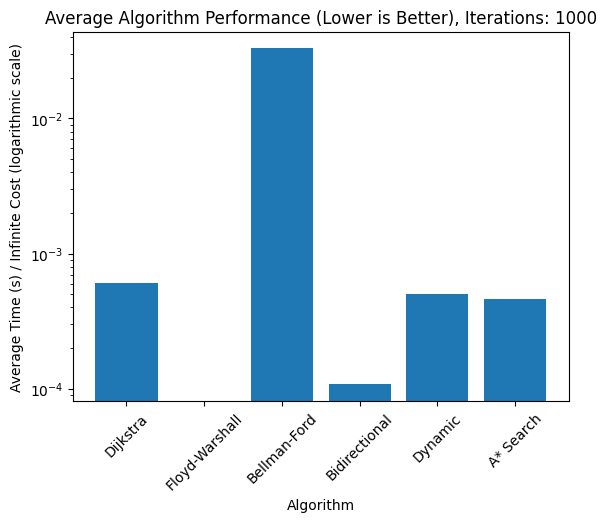

In [35]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Import Graph of Metro Manila


In [17]:
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [121.0017, 14.5361]
  },
  "properties": {}
}
'''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI = AOI.buffer(0.01)
AOI

0    POLYGON ((121.01170 14.53610, 121.01165 14.535...
dtype: geometry

In [18]:
WEST_BBOX, SOUTH_BBOX, EAST_BBOX, NORTH_BBOX = AOI.total_bounds

In [19]:
# bounding box for Metro Manila
# NORTH_BBOX = 14.7430
# SOUTH_BBOX = 14.4560
# WEST_BBOX = 120.9306
# EAST_BBOX = 121.1353

In [20]:
METRO_MANILA_BOUNDING_BOX = (NORTH_BBOX, SOUTH_BBOX, EAST_BBOX, WEST_BBOX)

In [21]:
metro_manila_graph = ox.graph_from_bbox(bbox=METRO_MANILA_BOUNDING_BOX)

C:\Users\Jed Padro\AppData\Local\Temp\ipykernel_16340\4238480312.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  metro_manila_graph = ox.graph_from_bbox(bbox=METRO_MANILA_BOUNDING_BOX)


In [22]:
def add_weight_from_length(G):
    # Iterate through each edge and set 'weight' to the value of 'length'
    for u, v, data in G.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']  # Copy 'length' to 'weight'
        else:
            data['weight'] = 0  # Set a default weight if 'length' is missing

add_weight_from_length(metro_manila_graph)

In [54]:
ox.save_graphml(metro_manila_graph, '../graphs/graphml/metro_manila_graph_small.graphml')

In [19]:
fp = '../graphs/graphml/metro_manila_graph.graphml'
metro_manila_graph = ox.load_graphml(fp)

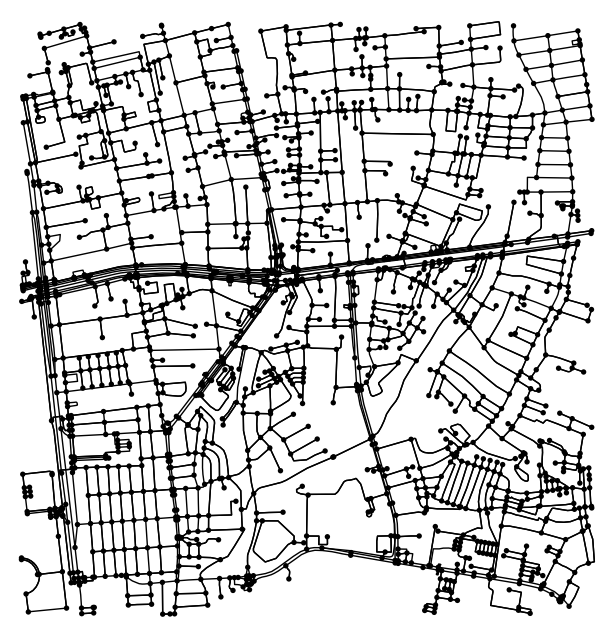

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [23]:
ox.plot_graph(metro_manila_graph, bgcolor='#ffffff', node_color='#000000', edge_color='#000000')

In [16]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(metro_manila_graph)

In [17]:
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
12067302,14.541506,120.994972,3,NaN,NaN,POINT (120.99497 14.54151)
12067308,14.537867,120.995733,3,NaN,NaN,POINT (120.99573 14.53787)
12067317,14.540634,120.992152,3,NaN,NaN,POINT (120.99215 14.54063)
12067355,14.538879,121.010825,3,NaN,NaN,POINT (121.01083 14.53888)
12072883,14.555428,121.004165,4,NaN,NaN,POINT (121.00417 14.55543)


In [18]:
gdf_edges.head()

osmid                   name  \
u        v          key                                                  
12067302 1686647100 0                   2667105     E. Manaloto Street   
         2950125788 0                 224039651  F. B. Harrison Street   
         6510185271 0                 224039651  F. B. Harrison Street   
12067308 8562405196 0                 224039655  F. B. Harrison Street   
         1723298722 0    [644875507, 840378998]                   EDSA   

                             highway  oneway reversed   length   weight  \
u        v          key                                                   
12067302 1686647100 0    residential   False     True  129.271  129.271   
         2950125788 0      secondary   False    False   34.788   34.788   
         6510185271 0      secondary   False     True   64.711   64.711   
12067308 8562405196 0      secondary   False     True    6.003    6.003   
         1723298722 0          trunk    True    False  175.734  175.734   

                          lanes maxspeed width  \
u        v          key                          
12067302 1686647100 0       NaN      NaN   NaN   
         2950125788 0         2       40     8   
         6510185271 0         2       40     8   
12067308 8562405196 0         2       40     8   
         1723298722 0    [4, 5]       60   NaN   

                                                                  geometry  \
u        v          key                                                      
12067302 1686647100 0    LINESTRING (120.99497 14.54151, 120.99380 14.5...   
         2950125788 0    LINESTRING (120.99497 14.54151, 120.99504 14.5...   
         6510185271 0    LINESTRING (120.99497 14.54151, 120.99486 14.5...   
12067308 8562405196 0    LINESTRING (120.99573 14.53787, 120.99572 14.5...   
         1723298722 0    LINESTRING (120.99573 14.53787, 120.99516 14.5...   

                         ref access service junction tunnel bridge  
u        v          key                                             
12067302 1686647100 0    NaN    NaN     NaN      NaN    NaN    NaN  
         2950125788 0    NaN    NaN     NaN      NaN    NaN    NaN  
         6510185271 0    NaN    NaN     NaN      NaN    NaN    NaN  
12067308 8562405196 0    NaN    NaN     NaN      NaN    NaN    NaN  
         1723298722 0      1    NaN     NaN      NaN    NaN    NaN

In [19]:
gdf_edges.columns

Index(['osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'weight',
       'lanes', 'maxspeed', 'width', 'geometry', 'ref', 'access', 'service',
       'junction', 'tunnel', 'bridge'],
      dtype='object')

In [20]:
gdf_nodes.columns

Index(['y', 'x', 'street_count', 'highway', 'ref', 'geometry'], dtype='object')

In [21]:
path = graph_search_algorithm_compilation.bidirectional_search(metro_manila_graph, 12067302, 12067308)
path

[12067302,
 2950125788,
 5354424837,
 24785165,
 5651175582,
 25388521,
 8317435077,
 25389123,
 25388522,
 978165773,
 445413656,
 8562405196,
 12067308]

#### Monte Carlo with Graph of Metro Manila

In [ ]:
iterations = 1
flooded_road_probability = 0.1
metro_manila_graph_flooded = apply_flood_conditions(metro_manila_graph.copy(), flooded_road_probability)
algorithm_performance = monte_carlo_simulation(metro_manila_graph, iterations)

  0%|          | 0/1 [20:49<?, ?it/s]


KeyboardInterrupt: 

Best algorithm: Dijkstra
Dijkstra: inf seconds (average)
Floyd-Warshall: inf seconds (average)
Bellman-Ford: inf seconds (average)
Bidirectional: inf seconds (average)
Dynamic: inf seconds (average)
A* Search: inf seconds (average)
Yen's K-Shortest Paths: inf seconds (average)
Best path found by Dijkstra: []


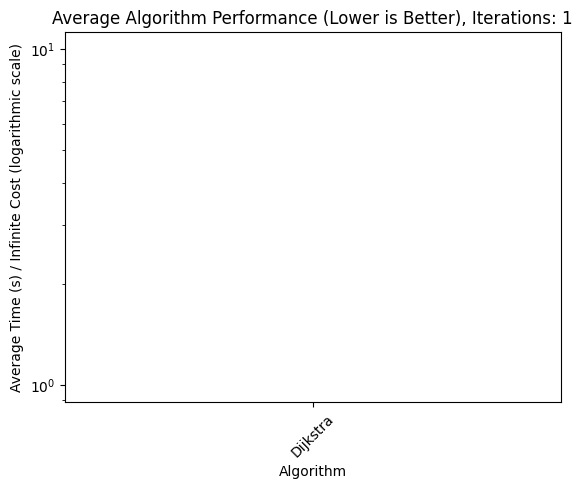

In [53]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Conclusion